# Predicting Terrorist Attacks
### Author: Or Yosef Nejar

## Forcasting of periodic events and their location with Machine Learning
Using the Global Terrorism Database and scikit-learn, I compared the effectiveness of different machine learning algorithms in predicting where and when terrorist attacks would occur.

I will split my research to parts: 
1. Forcasting the date based on past dates
2. Forcasting the country of where it will occur basted on all collected data.

## Setup
First of all, I need to import the following libraries.

In [1]:
## for data
import pandas as pd
import numpy as np

## for plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pylab as pl
plt.rcParams['figure.figsize'] = (20, 12)
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

## for machine learning
import xgboost as xgb
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.preprocessing import LabelEncoder



## for statistical tests
import scipy
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy.special import expit
from scipy.special import logit

# Manipulation with dates
from datetime import date
from dateutil.relativedelta import relativedelta



## Load the Datasets
For this project I've created the most updated dataset, which covers the years 2015-2019.

In [3]:
df = pd.read_csv('output.csv', header=0, sep=',', index_col=0)


## Inspect the Structure
The data frame contains 7 attributes,  and 50,000 observations.

In [4]:
# Display a summary of the data frame
df.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Date         50000 non-null  object
 1   Country      50000 non-null  object
 2   City         50000 non-null  object
 3   Perpetrator  50000 non-null  object
 4   Fatalities   50000 non-null  object
 5   Injured      50000 non-null  object
 6   Target       50000 non-null  object
dtypes: object(7)
memory usage: 3.1+ MB


## Taking care of all the 'Unknown' values
The replace_cols function receive:
1. A dataframe
2. The column name 
3. The value to replace 
4. The value to replace it with.

Every numeric colummn, the 'Unknown' was replaced with '0' and than transformed from str to int.

Every Categorial column, the 'Unknown' was replaced with 'NaN' value.

In [5]:
def replace_cols(dataframe, cols_to_replace, obj_to_replace, replacement):
    dataframe[cols_to_replace] = dataframe[cols_to_replace].replace(obj_to_replace, replacement)
    return dataframe

In [6]:
cols_to_replace = ['Fatalities', 'Injured']
# df[cols_to_replace] = df[cols_to_replace].replace('Unknown', '0')
df = replace_cols(df, cols_to_replace, 'Unknown', '0' )
df[cols_to_replace] = df[cols_to_replace].astype(str).astype(int)
cols_to_replace =['Perpetrator', 'Target']
df = replace_cols(df, cols_to_replace, 'Unknown', np.nan)
df.head()

,Date,Country,City,Perpetrator,Fatalities,Injured,Target
0,2019-12-31,China,Hong Kong,NaN,0,0,Government (General)
1,2019-12-31,India,Bagiot Dora,NaN,0,1,Private Citizens & Property
2,2019-12-31,Sudan,El Geneina,NaN,2,0,"Government (General),Police"
3,2019-12-31,Sudan,El Geneina,NaN,2,1,Police
4,2019-12-31,Iraq,Baghdad,NaN,0,0,Private Citizens & Property


## Fixing 'Date' Column
Since the 'Date' column was collected from the GTD site it was past as Object of string.

I've converted it to dtype: datetime64

In [8]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y/%m/%d')
df['Date'].head(5)

0   2019-12-31
1   2019-12-31
2   2019-12-31
3   2019-12-31
4   2019-12-31
Name: Date, dtype: datetime64[ns]

## Categorical Columns
Converting all categorical columns from 'Object' type to 'category'

In [9]:
df['Country'] = df['Country'].astype('category')
df['City'] = df['City'].astype('category')
df['Perpetrator'] = df['Perpetrator'].astype('category')
df['Target'] = df['Target'].astype('category')

## Unique Values in each column

In [10]:
country_count = len(df['Country'].unique())
city_count = len(df['City'].unique())
perpetrator_count = len(df['Perpetrator'].unique())
target_count = len(df['Target'].unique())
year_count = len(df['Date'].unique())
print("Countrys: ")
print(country_count)
print("Cities: ")
print(city_count)
print("Perpetrators: ")
print(perpetrator_count)
print("Target: ")
print(target_count)
print("Years: ")
print(year_count)

Countrys: 
140
Cities: 
17670
Perpetrators: 
1415
Target: 
389
Years: 
1627


## Missing values
We need to handle all the missing values.

Lets start by getting an overview of the whole dataset, in particular I want to know how many categorical and numerical variables there are and the proportion of missing data. 

Recognizing a variable’s type sometimes can be tricky because categories can be expressed as numbers


In [11]:
'''
Recognize whether a column is numerical or categorical.
:parameter
    :param dtf: dataframe - input data
    :param col: str - name of the column to analyze
    :param max_cat: num - max number of unique values to recognize a column as categorical
:return
    "cat" if the column is categorical or "num" otherwise
'''
def utils_recognize_type(dtf, col, max_cat=20):
    if (dtf[col].dtype == "category") | (dtf[col].nunique() < max_cat):
        return "cat"
    else:
        return "num"

This function is very useful and can be used in several occasions. To give an illustration I’ll plot a heatmap of the dataframe to visualize columns type and missing data.

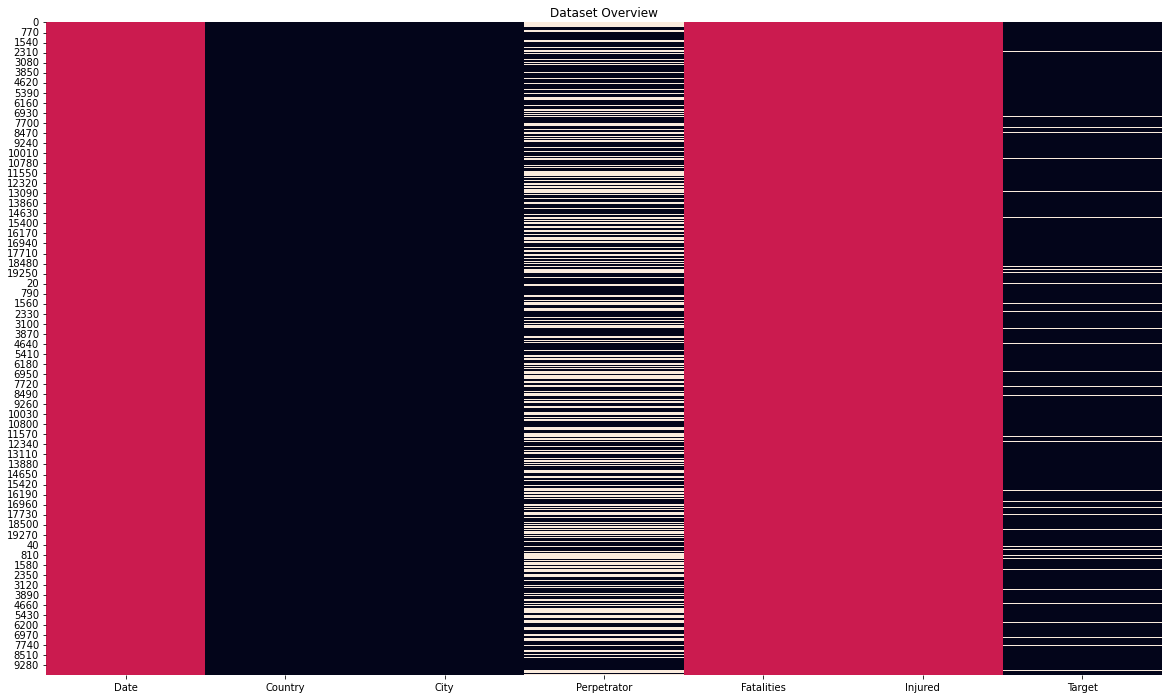

 Categerocial   Numeric   NaN 


In [12]:
dic_cols = {col:utils_recognize_type(df, col, max_cat=20) for col in df.columns}

heatmap = df.isnull()
for k,v in dic_cols.items():
    if v == "num":
        heatmap[k] = heatmap[k].apply(lambda x: 0.5 if x is False else 1)
    else:
        heatmap[k] = heatmap[k].apply(lambda x: 0 if x is False else 1)

sns.heatmap(heatmap, cbar=False).set_title('Dataset Overview')
plt.show()
print("\033[1;37;40m Categerocial ", "\033[1;30;41m Numeric ", "\033[1;30;47m NaN ")

In [14]:
print('number of missing data:')
print(df.isnull().sum())
df.describe(include='all')

number of missing data:
Date               0
Country            0
City               0
Perpetrator    19437
Fatalities         0
Injured            0
Target          3381
dtype: int64


C:\Users\ornir\AppData\Local\Temp\ipykernel_1136\525267331.py:3: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.describe(include='all')


,Date,Country,City,Perpetrator,Fatalities,Injured,Target
count,50000,50000,50000,30563,50000.000000,50000.000000,46619
unique,1627,140,17670,1414,NaN,NaN,388
top,2016-09-21 00:00:00,Iraq,Baghdad,Taliban,NaN,NaN,Private Citizens & Property
freq,133,9171,2151,4905,NaN,NaN,14442
first,2015-06-22 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
last,2019-12-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,2.424220,2.500660,NaN
std,NaN,NaN,NaN,NaN,8.967255,12.504232,NaN
min,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN
25%,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN


In [15]:
df = df.fillna(df.mode().iloc[0])
df_nan = df[df.isna().any(axis=1)]
print(df_nan)

Empty DataFrame
Columns: [Date, Country, City, Perpetrator, Fatalities, Injured, Target]
Index: []


In [16]:
year_df = df.copy()
year_df['Date'] = pd.DatetimeIndex(year_df['Date']).year
year_df.head()

,Date,Country,City,Perpetrator,Fatalities,Injured,Target
0,2019,China,Hong Kong,Taliban,0,0,Government (General)
1,2019,India,Bagiot Dora,Taliban,0,1,Private Citizens & Property
2,2019,Sudan,El Geneina,Taliban,2,0,"Government (General),Police"
3,2019,Sudan,El Geneina,Taliban,2,1,Police
4,2019,Iraq,Baghdad,Taliban,0,0,Private Citizens & Property


<AxesSubplot:xlabel='Date'>

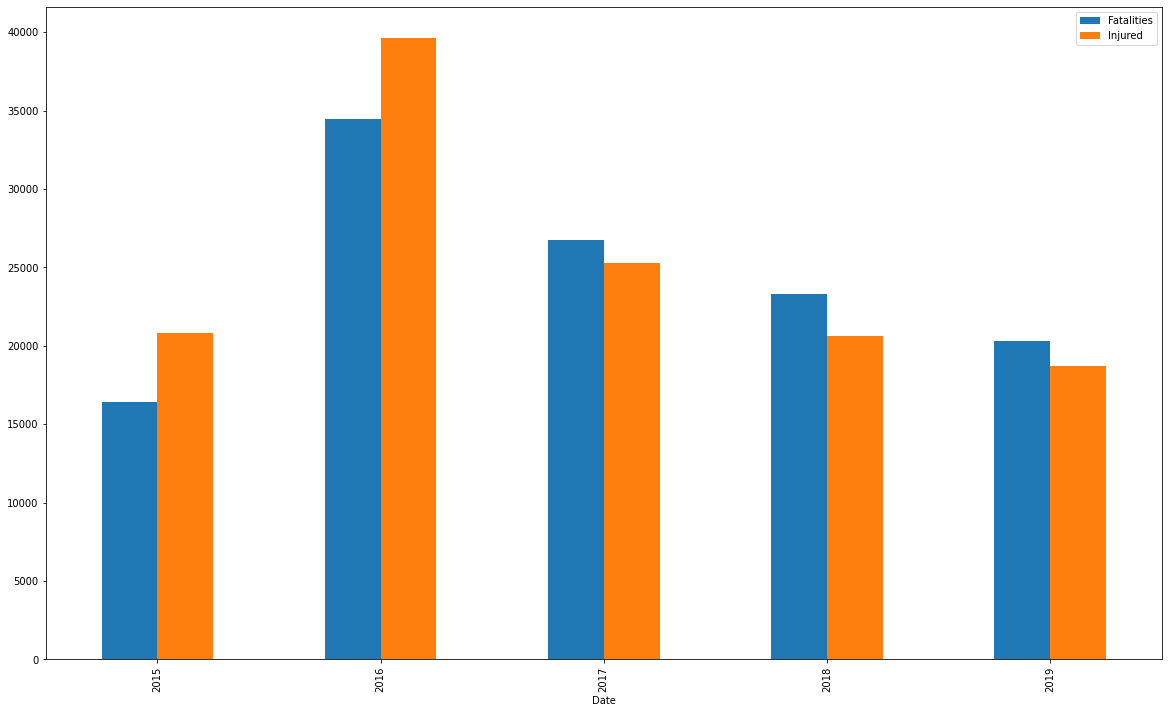

In [17]:
year_df.groupby(year_df['Date']).sum().plot(kind='bar')

In [18]:
test_df = df.copy()

In [ ]:
# test_df['Perpetrator'] = test_df['Perpetrator'].cat.as_ordered()
# test_df['Target'] = test_df['Target'].cat.as_ordered()
# test_df['Country'] = test_df['Country'].cat.as_ordered()

# for col in test_df.columns.values:
#     if test_df[col].isnull().sum() == 0:
#         continue
#     if col == 'Perpetrator':
#         guess_values = test_df.groupby('Country')['Perpetrator'].apply(lambda x: x.mode().max())
#     if col == 'Target':
#         guess_values = test_df.groupby('Country')['Target'].apply(lambda x: x.mode().max())
#     if col == 'City':
#         guess_values = test_df.groupby('Country')['City'].apply(lambda x: x.mode().max())
#     for country_row in test_df['Country'].unique():
#         test_df[col].loc[(test_df[col].isnull())&(test_df['Country']==country_row)] = guess_values[country_row]
# print(test_df.isnull().sum())

let’s have a look at the univariate distributions (probability distribution of just one variable). 

A bar plot is appropriate to understand labels frequency for a single categorical variable. 

For example, let’s plot the Country variable:

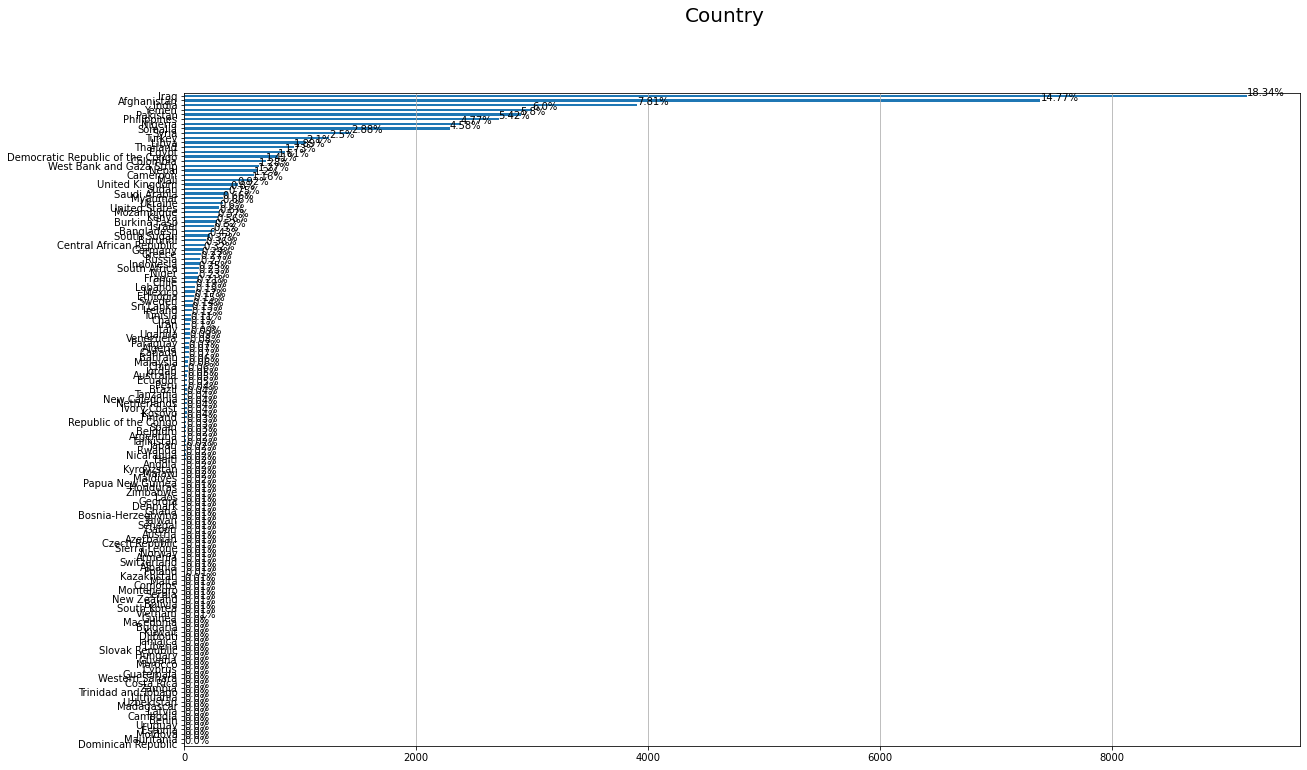

In [19]:
country = "Country"
ax = test_df[country].value_counts().sort_values().plot(kind="barh")
totals= []
for i in ax.patches:
    totals.append(i.get_width())
total = sum(totals)
for i in ax.patches:
     ax.text(i.get_width()+.3, i.get_y()+.20, 
     str(round((i.get_width()/total)*100, 2))+'%', 
     fontsize=10, color='black')
ax.grid(axis="x")
plt.suptitle(country, fontsize=20)
plt.show()

C:\Users\ornir\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\ornir\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\ornir\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\function_base.py:4486: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
C:\Users\ornir\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\cbook\__init__.py:1220: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\Users\ornir\AppData\Local\Program

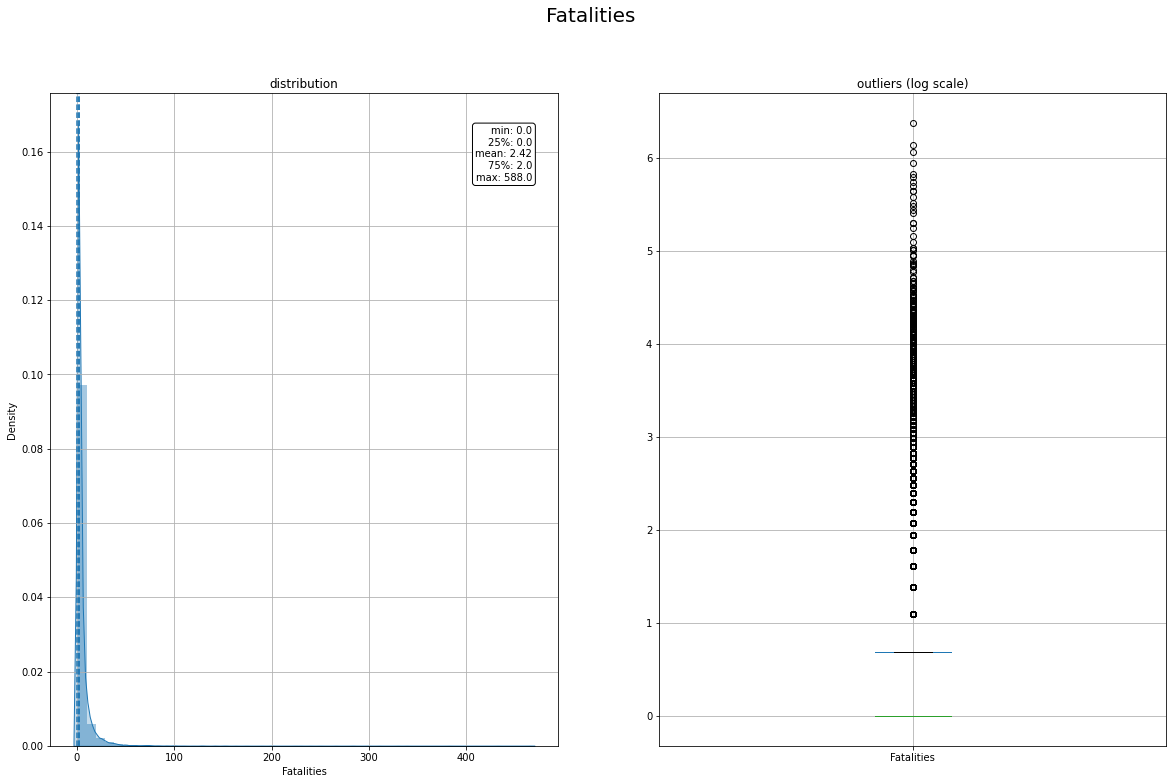

In [20]:
x = "Fatalities"

fig, ax = plt.subplots(nrows=1, ncols=2,  sharex=False, sharey=False)
fig.suptitle(x, fontsize=20)

### distribution
ax[0].title.set_text('distribution')
variable = test_df[x].fillna(test_df[x].mean())
breaks = np.quantile(variable, q=np.linspace(0, 1, 11))
variable = variable[ (variable > breaks[0]) & (variable < 
                    breaks[10]) ]
sns.distplot(variable, hist=True, kde=True, kde_kws={"shade": True}, ax=ax[0])
des = test_df[x].describe()
ax[0].axvline(des["25%"], ls='--')
ax[0].axvline(des["mean"], ls='--')
ax[0].axvline(des["75%"], ls='--')
ax[0].grid(True)
des = round(des, 2).apply(lambda x: str(x))
box = '\n'.join(("min: "+des["min"], "25%: "+des["25%"], "mean: "+des["mean"], "75%: "+des["75%"], "max: "+des["max"]))
ax[0].text(0.95, 0.95, box, transform=ax[0].transAxes, fontsize=10, va='top', ha="right", bbox=dict(boxstyle='round', facecolor='white', alpha=1))

### boxplot 
ax[1].title.set_text('outliers (log scale)')
tmp_df = pd.DataFrame(test_df[x])
tmp_df[x] = np.log(tmp_df[x])
tmp_df.boxplot(column=x, ax=ax[1])
plt.show()

In [ ]:
cat, num = "Date", "Fatalities"
fig, ax = plt.subplots(nrows=1, ncols=3,  sharex=False, sharey=False)
fig.suptitle(x+"   vs   "+country, fontsize=20)
            
### distribution
ax[0].title.set_text('density')
for i in test_df[cat].unique():
    sns.distplot(test_df[test_df[cat]==i][num], hist=False, label=i, ax=ax[0])
ax[0].grid(True)
### stacked
ax[1].title.set_text('bins')
breaks = np.quantile(test_df[num], q=np.linspace(0,1,11))
tmp = test_df.groupby([cat, pd.cut(test_df[num], breaks, duplicates='drop')]).size().unstack().T
tmp = tmp[test_df[cat].unique()]
tmp["tot"] = tmp.sum(axis=1)
for col in tmp.drop("tot", axis=1).columns:
     tmp[col] = tmp[col] / tmp["tot"]
tmp.drop("tot", axis=1).plot(kind='bar', stacked=True, ax=ax[1], legend=False, grid=True)
### boxplot   
ax[2].title.set_text('outliers')
sns.catplot(x=cat, y=num, data=test_df, kind="box", ax=ax[2])
ax[2].grid(True)
plt.show()

## Part -1: Forecasting of terror attacks that occur periodically based on dates of previous terror attacks.
In this first part I will take from my dataframe only the 'Date'

Having this in mind and previous history of Terror attack dates, we want to predict potential date or range of dates when the next data terror attack might happen.

Goal: we need to predict what is the date of the next terror attaks.

## Data preparation
After the base cleaning step we did on our dataframe, lets now build a new dataframe only with a date column

In [22]:
date_df = pd.DataFrame(df['Date'])

date_df['Date'] = pd.to_datetime(date_df['Date'])
date_df['terror_attack'] = 1

date_df2 = date_df.groupby(['Date'])['terror_attack'].sum().reset_index()
print(date_df2)


           Date  terror_attack
0    2015-06-22              1
1    2015-06-30              1
2    2015-07-11              1
3    2015-07-13              1
4    2015-07-14             23
...         ...            ...
1622 2019-12-27             19
1623 2019-12-28             19
1624 2019-12-29             21
1625 2019-12-30             18
1626 2019-12-31             29

[1627 rows x 2 columns]


We also should add a column with 0 and 1 values to specify if a terror attack happened on this date. 

For now, we only have dates of terror attacks, so we create a column filled with 1 values.

In [23]:
print(date_df)

           Date  terror_attack
0    2019-12-31              1
1    2019-12-31              1
2    2019-12-31              1
3    2019-12-31              1
4    2019-12-31              1
...         ...            ...
9995 2015-07-14              1
9996 2015-07-14              1
9997 2015-07-14              1
9998 2015-07-14              1
9999 2015-07-14              1

[50000 rows x 2 columns]


After that, we need to create all rows for dates between terror attacks in DataFrame and fill terror_attack column with zeros for them.

In [24]:
r = pd.date_range(start=date_df2['Date'].min(), end=date_df2['Date'].max())
date_df2 = date_df2.set_index('Date').reindex(r, fill_value=0).rename_axis('Date').reset_index()



In [25]:
print(date_df2)

           Date  terror_attack
0    2015-06-22              1
1    2015-06-23              0
2    2015-06-24              0
3    2015-06-25              0
4    2015-06-26              0
...         ...            ...
1649 2019-12-27             19
1650 2019-12-28             19
1651 2019-12-29             21
1652 2019-12-30             18
1653 2019-12-31             29

[1654 rows x 2 columns]


## Feature engineering
Prediction of next terror attakcs dates heavily relies on feature engineering. Therefore, we will create the following features:

* Month
* A calendar day of the month
* Working day number
* Day of the week

In [26]:
date_df2['Month'] = date_df2['Date'].dt.month
date_df2['Day'] = date_df2['Date'].dt.day
date_df2['Workday_N'] = np.busday_count(
                    date_df2['Date'].values.astype('datetime64[M]'),
                    date_df2['Date'].values.astype('datetime64[D]'))
date_df2['Week_day'] = date_df2['Date'].dt.weekday
# date_df2['Week_of_month'] = (date_df2['Date'].dt.day 
#                          - date_df2['Date'].dt.weekday - 2) // 7 + 2
# date_df2['Weekday_order'] = (date_df2['Date'].dt.day + 6) // 7
date_df2 = date_df2.set_index('Date')
print(date_df2)

            terror_attack  Month  Day  Workday_N  Week_day
Date                                                      
2015-06-22              1      6   22         15         0
2015-06-23              0      6   23         16         1
2015-06-24              0      6   24         17         2
2015-06-25              0      6   25         18         3
2015-06-26              0      6   26         19         4
...                   ...    ...  ...        ...       ...
2019-12-27             19     12   27         19         4
2019-12-28             19     12   28         20         5
2019-12-29             21     12   29         20         6
2019-12-30             18     12   30         20         0
2019-12-31             29     12   31         21         1

[1654 rows x 5 columns]


In [27]:
date_df2['terror_attack'].unique()

array([  1,   0,  23,  38,  40,  32,  17,  39,  46,  31,  55,  36,  61,
        33,  35,  25,  43,  53,  44,  42,  41,  49,  45,  37,  30,  62,
        57,  50,  48,  34,  26,  63,  54,  29,  11,  58,  28,  47,  24,
        59,  27,  51,  77,  18,  64,  71,  22,  56,  52,  66,  21,  84,
        60,  79,  70,  90, 133, 103,  20,  19,  15,  16,  13,   8,  12,
        14,  97,   6,   9,  10,  68], dtype=int64)

<AxesSubplot:xlabel='Date'>

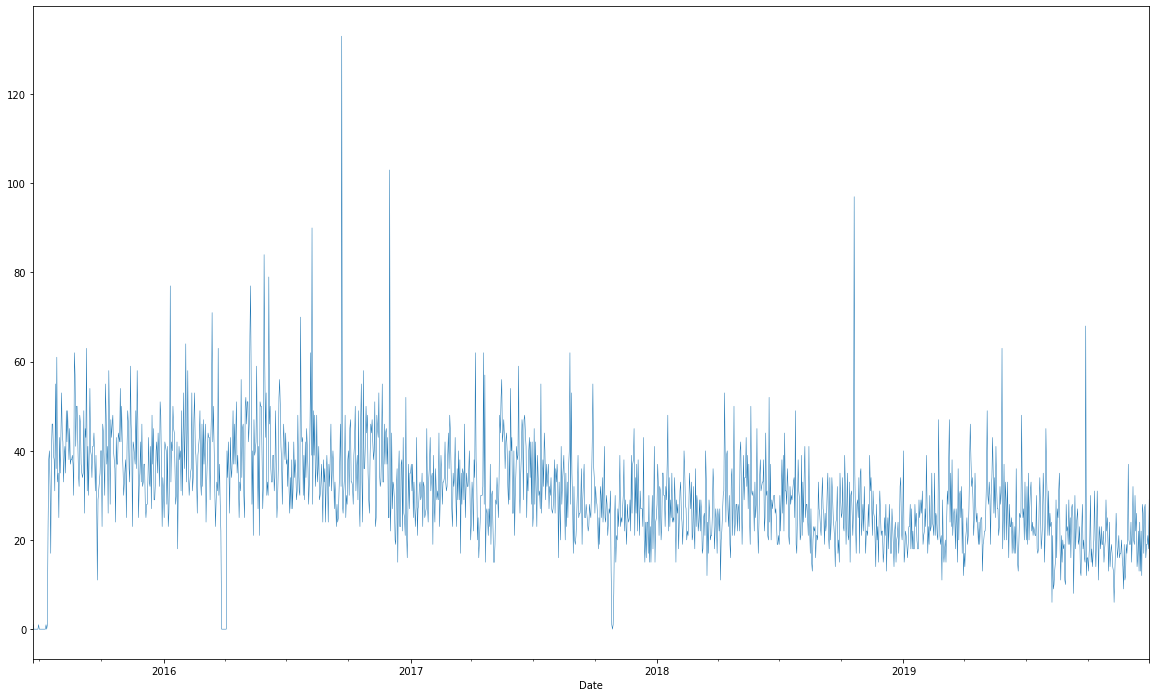

In [28]:
date_df2['terror_attack'].plot(linewidth=0.5)

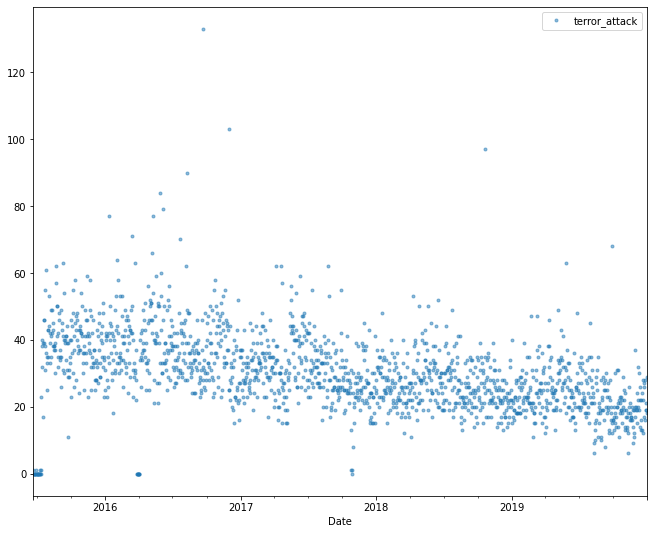

In [29]:
cols_plot = ['terror_attack']
axes = date_df2[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)

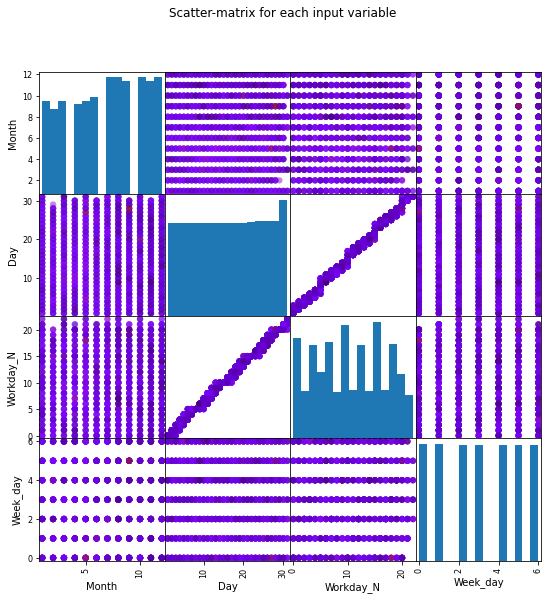

In [30]:
feature_names = ['Month', 'Day', 'Workday_N', 'Week_day']
X = date_df2[feature_names]
y = date_df2['terror_attack']

cmap = cm.get_cmap('gnuplot')
scatter = pd.plotting.scatter_matrix(X, c = y, marker = 'o', s=40, hist_kwds={'bins':15}, figsize=(9,9), cmap = cmap)
plt.suptitle('Scatter-matrix for each input variable')
plt.savefig('fruits_scatter_matrix')

In [31]:
cor = date_df2.corr(method='pearson')
cor.style.background_gradient(cmap='coolwarm').set_precision(2)

C:\Users\ornir\AppData\Local\Temp\ipykernel_1136\967957617.py:2: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  cor.style.background_gradient(cmap='coolwarm').set_precision(2)


,terror_attack,Month,Day,Workday_N,Week_day
terror_attack,1.00,-0.05,0.00,-0.00,-0.05
Month,-0.05,1.00,0.01,-0.00,0.00
Day,0.00,0.01,1.00,1.00,-0.01
Workday_N,-0.00,-0.00,1.00,1.00,0.05
Week_day,-0.05,0.00,-0.01,0.05,1.00


## Training Machine learning model
We need to split our dataset into two parts: train and test. we will set shuffle argument to False, because our goal is to create a forecast based on past events.

In [32]:
x_train, x_test, y_train, y_test = train_test_split(date_df2.drop(['terror_attack'], axis=1), date_df2['terror_attack'],
                 test_size=0.35, random_state=1, shuffle=False)

In general, shuffle helps to get rid of overfitting by choosing different training observations. But it is not our case, every time we should have all history of publication events.

In order to choose the best prediction model, we will test the following models:

* XGBoost
* K-nearest Neighbors (KNN)
* RandomForest
* Logistic Regression
* Decision Tree


#### XGBoost
We will use XGBoost with tree base learners and grid search method to choose the best parameters. It searches over all possible combinations of parameters and chooses the best based on cross-validation evaluation.

A drawback of this approach is a long computation time.

Alternatively, the random search can be used. It iterates over the given range given the number of times, choosing values randomly. After a certain number of iterations, it chooses the best model.

However, when you have a large number of parameters, random search tests a relatively low number of combinations. It makes finding a really optimal combination almost impossible.

To use grid search you need to specify the list of possible values for each parameter.

In [33]:
DM_train = xgb.DMatrix(data=x_train, label=y_train)
grid_param = {"learning_rate": [0.01, 0.1],
              "n_estimators": [100, 150, 200],
              "alpha": [0.1, 0.5, 1],
              "max_depth": [2, 3, 4]}
model = xgb.XGBRegressor()
grid_mse = GridSearchCV(estimator=model, param_grid=grid_param,
                       scoring="neg_mean_squared_error",
                       cv=4, verbose=1)
grid_mse.fit(x_train, y_train)
print("Best parameters found: ", grid_mse.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(grid_mse.best_score_)))

Fitting 4 folds for each of 54 candidates, totalling 216 fits
Best parameters found:  {'alpha': 0.1, 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100}
Lowest RMSE found:  13.231128892013029


We see the best parameters for our XGBoost model are: 

{'alpha': 0.1, 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100}

Let’s train the model with obtained parameters.

In [34]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)

In [35]:
xgb_model = xgb.XGBClassifier(objective ='reg:squarederror', colsample_bytree = 1, learning_rate = 0.1,max_depth = 2, alpha = 0.5, n_estimators = 100)
xgb_model.fit(x_train, y_train)
xgb_prediction = xgb_model.predict(x_test)
print('Accuracy of XGB Model classifier on training set: {:.2f}'
     .format(xgb_model.score(x_train, y_train)))
print('Accuracy of XGB Model classifier on test set: {:.2f}'
     .format(xgb_model.score(x_test, y_test)))

Accuracy of XGB Model classifier on training set: 0.22
Accuracy of XGB Model classifier on test set: 0.03


In [36]:
logreg = LogisticRegression()
logreg.fit(x_train, y_train)
print('Accuracy of Logistic regression classifier on training set: {:.2f}'
     .format(logreg.score(x_train, y_train)))
print('Accuracy of Logistic regression classifier on test set: {:.2f}'
     .format(logreg.score(x_test, y_test)))

Accuracy of Logistic regression classifier on training set: 0.06
Accuracy of Logistic regression classifier on test set: 0.04


C:\Users\ornir\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### K-nearest Neighbors (KNN)
K-nearest neighbors model is meant to be used when you are trying to find similarities between observations.

 This is exactly our case because we are trying to find patterns in the past release dates.

In [37]:
knn = KNeighborsClassifier(n_neighbors = 3, algorithm = 'auto',     
                           weights = 'distance') 
knn.fit(x_train, y_train)  
knn_prediction = knn.predict(x_test)
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(x_train, y_train)))
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(x_test, y_test)))

print(accuracy_score(y_test, knn_prediction))

Accuracy of K-NN classifier on training set: 1.00
Accuracy of K-NN classifier on test set: 0.03
0.031088082901554404


### Random Forest
Random forest basic model parameters tuning usually doesn’t take a lot of time.

You simply iterate over the possible number of estimators and the maximum depth of trees and choose optimal ones using elbow method.

In [38]:
random_forest = RandomForestClassifier(n_estimators=50,
                                       max_depth=10, random_state=1)
random_forest.fit(x_train, y_train)
rf_prediction = random_forest.predict(x_test)
print('Accuracy of Random Forest classifier on training set: {:.2f}'
     .format(random_forest.score(x_train, y_train)))
print('Accuracy of Random Forest classifier on test set: {:.2f}'
     .format(random_forest.score(x_test, y_test)))

print(accuracy_score(y_test, rf_prediction))

Accuracy of Random Forest classifier on training set: 0.96
Accuracy of Random Forest classifier on test set: 0.03
0.02936096718480138


In [39]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier().fit(x_train, y_train)
clf_prediction = clf.predict(x_test)
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(x_train, y_train)))
print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(clf.score(x_test, y_test)))

print(accuracy_score(y_test, clf_prediction))

Accuracy of Decision Tree classifier on training set: 1.00
Accuracy of Decision Tree classifier on test set: 0.03
0.03454231433506045


In [40]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis().fit(x_train, y_train)
lda_prediction = lda.predict(x_test)
print('Accuracy of LDA classifier on training set: {:.2f}'
     .format(lda.score(x_train, y_train)))
print('Accuracy of LDA classifier on test set: {:.2f}'
     .format(lda.score(x_test, y_test)))

print(accuracy_score(y_test, lda_prediction))

Accuracy of LDA classifier on training set: 0.06
Accuracy of LDA classifier on test set: 0.04
0.044905008635578586


In [41]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB().fit(x_train, y_train)
gnb_prediction = gnb.predict(x_test)
print('Accuracy of GNB classifier on training set: {:.2f}'
     .format(gnb.score(x_train, y_train)))
print('Accuracy of GNB classifier on test set: {:.2f}'
     .format(gnb.score(x_test, y_test)))

print(accuracy_score(y_test, gnb_prediction))

Accuracy of GNB classifier on training set: 0.07
Accuracy of GNB classifier on test set: 0.05
0.05181347150259067


### Comparing the results
We will use confusion matrix to evaluate performance of trained models. 

It helps us compare models side by side and understand whether our parameters should be tuned any further.

In [42]:
from sklearn.metrics import classification_report

xgb_matrix = metrics.confusion_matrix(xgb_prediction, y_test)
print(f"""
Confusion matrix for XGBoost model:
TN:{xgb_matrix[0][0]}    FN:{xgb_matrix[0][1]}
FP:{xgb_matrix[1][0]}    TP:{xgb_matrix[1][1]}""")
knn_matrix = metrics.confusion_matrix(knn_prediction, y_test)
print(f"""
Confusion matrix for KNN model:
TN:{knn_matrix[0][0]}    FN:{knn_matrix[0][1]}
FP:{knn_matrix[1][0]}    TP:{knn_matrix[1][1]}""")
rf_matrix = metrics.confusion_matrix(rf_prediction, y_test)
print(f"""
Confusion matrix for Random Forest model:
TN:{rf_matrix[0][0]}    FN:{rf_matrix[0][1]}
FP:{rf_matrix[1][0]}    TP:{rf_matrix[1][1]}""")




Confusion matrix for XGBoost model:
TN:0    FN:0
FP:0    TP:0

Confusion matrix for KNN model:
TN:0    FN:0
FP:0    TP:0

Confusion matrix for Random Forest model:
TN:0    FN:0
FP:0    TP:0


Now we need to create DataFrame with future dates for prediction and use trained RandomForest model to predict future releases for one year ahead.

In [43]:
x_predict = pd.DataFrame(pd.date_range(date.today(), (date.today() +
            relativedelta(years=1)),freq='d'), columns=['Date'])
x_predict['Day'] = x_predict['Date'].dt.day
x_predict['Workday_N'] = np.busday_count(
                x_predict['Date'].values.astype('datetime64[M]'),
                x_predict['Date'].values.astype('datetime64[D]'))
x_predict['Week_day'] = x_predict['Date'].dt.weekday
# x_predict['Week_of_month'] = (x_predict['Date'].dt.day - 
#                               x_predict['Date'].dt.weekday - 2)//7+2
# x_predict['Weekday_order'] = (x_predict['Date'].dt.day + 6) // 7
x_predict['Month'] = x_predict['Date'].dt.month
x_predict = x_predict.set_index('Date')
prediction = random_forest.predict(x_predict)
x_predict['Prediction'] = prediction
x_predict.head(200)


C:\Users\ornir\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


,Day,Workday_N,Week_day,Month,Prediction
Date,,,,,
2022-07-08,8,5,4,7,24
2022-07-09,9,6,5,7,17
2022-07-10,10,6,6,7,17
2022-07-11,11,6,0,7,32
2022-07-12,12,7,1,7,13
...,...,...,...,...,...
2023-01-19,19,13,3,1,34
2023-01-20,20,14,4,1,19
2023-01-21,21,15,5,1,39


That’s it — we created forecast of terror attack dates for one year ahead.

## Part-2: Country prediction

In [44]:
country_df = test_df.copy()
country_df.head()

,Date,Country,City,Perpetrator,Fatalities,Injured,Target
0,2019-12-31,China,Hong Kong,Taliban,0,0,Government (General)
1,2019-12-31,India,Bagiot Dora,Taliban,0,1,Private Citizens & Property
2,2019-12-31,Sudan,El Geneina,Taliban,2,0,"Government (General),Police"
3,2019-12-31,Sudan,El Geneina,Taliban,2,1,Police
4,2019-12-31,Iraq,Baghdad,Taliban,0,0,Private Citizens & Property


Let's add the same columns we had from previous part, to have more attributes for prediction.

In [45]:
country_df['Year'] = country_df['Date'].dt.year
country_df['Month'] = country_df['Date'].dt.month
country_df['Day'] = country_df['Date'].dt.day
country_df['Workday_N'] = np.busday_count(
                    country_df['Date'].values.astype('datetime64[M]'),
                    country_df['Date'].values.astype('datetime64[D]'))
country_df['Week_day'] = country_df['Date'].dt.weekday
country_df = country_df.set_index('Date')


In [46]:
country_df.head()

,Country,City,Perpetrator,Fatalities,Injured,Target,Year,Month,Day,Workday_N,Week_day
Date,,,,,,,,,,,
2019-12-31,China,Hong Kong,Taliban,0,0,Government (General),2019,12,31,21,1
2019-12-31,India,Bagiot Dora,Taliban,0,1,Private Citizens & Property,2019,12,31,21,1
2019-12-31,Sudan,El Geneina,Taliban,2,0,"Government (General),Police",2019,12,31,21,1
2019-12-31,Sudan,El Geneina,Taliban,2,1,Police,2019,12,31,21,1
2019-12-31,Iraq,Baghdad,Taliban,0,0,Private Citizens & Property,2019,12,31,21,1


<AxesSubplot:ylabel='Perpetrator'>

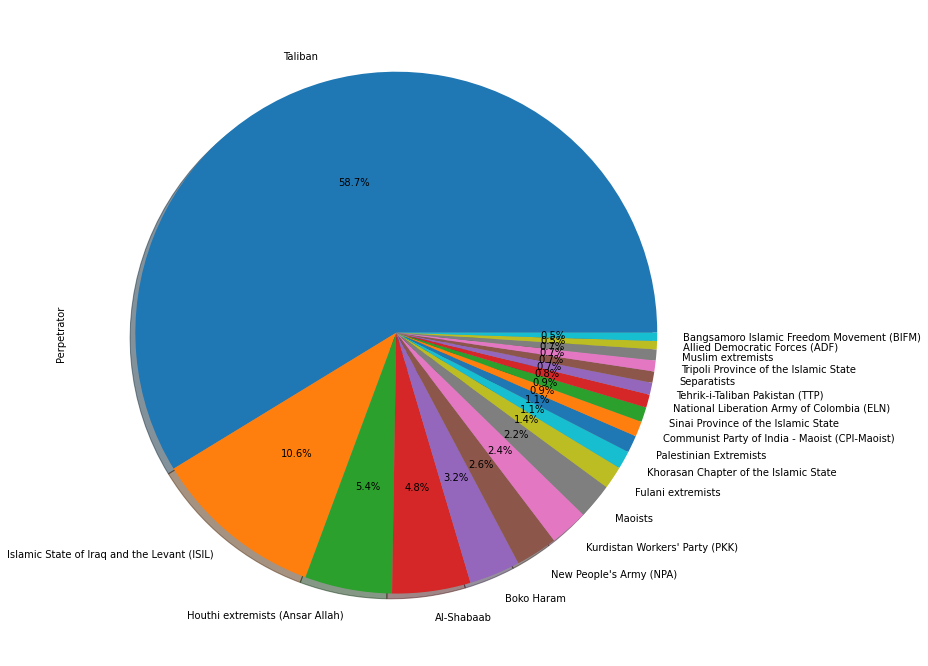

In [47]:
df['Perpetrator'].value_counts().head(20).plot(kind='pie', y='Target', shadow = True, autopct='%1.1f%%')

<AxesSubplot:ylabel='Target'>

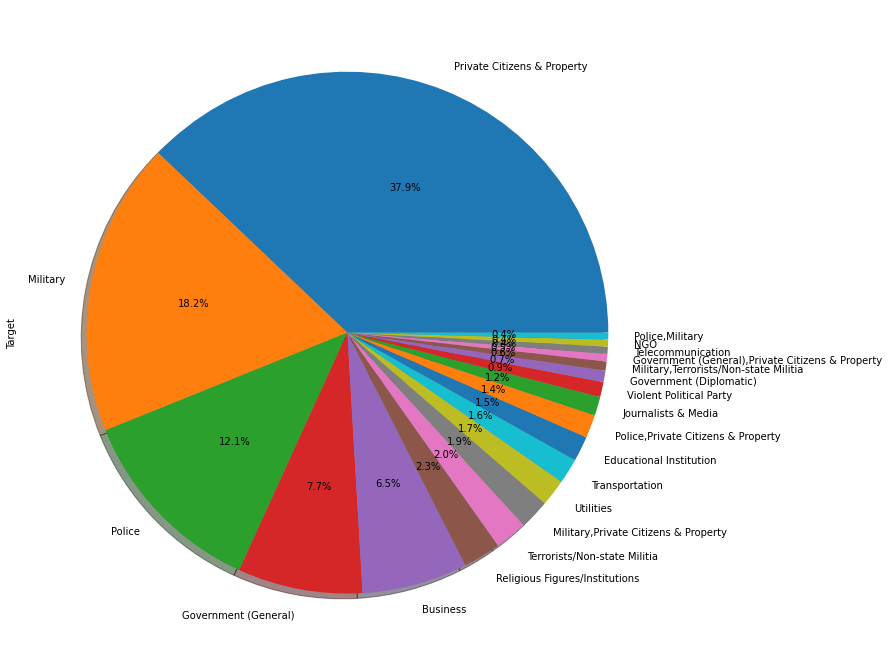

In [48]:
df['Target'].value_counts().head(20).plot(kind='pie', y='Target', shadow = True, autopct='%1.1f%%')

<AxesSubplot:xlabel='Year'>

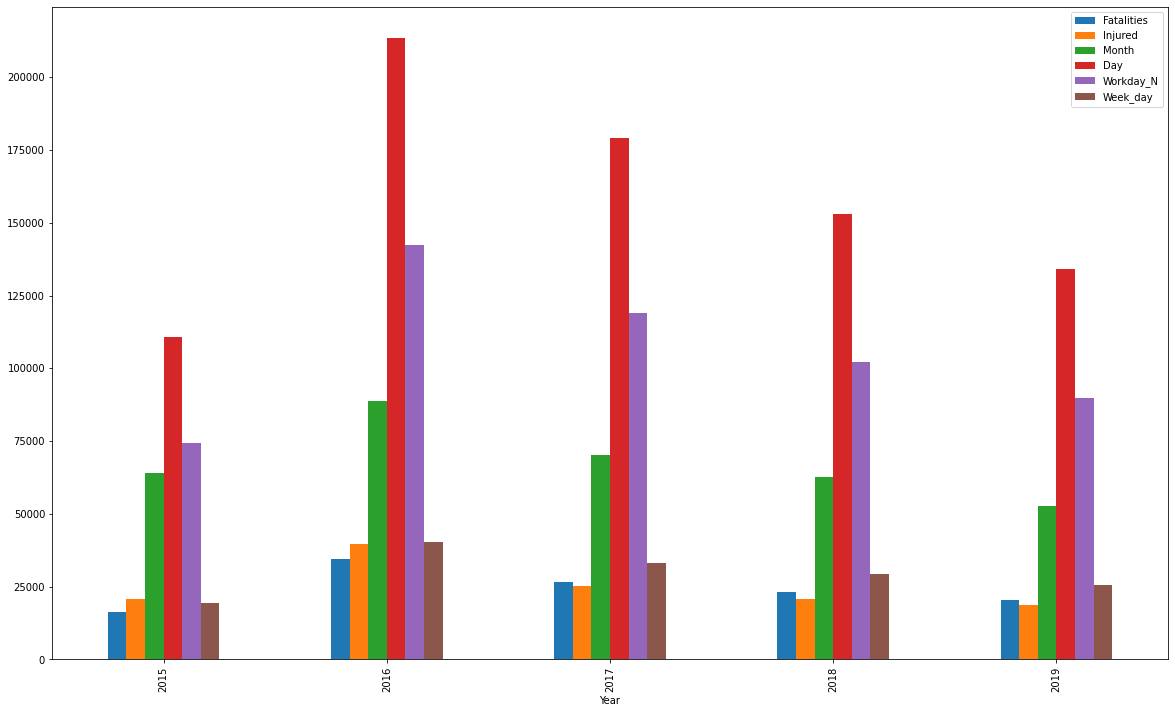

In [49]:
country_df.groupby(country_df['Year']).sum().plot(kind='bar')

C:\Users\ornir\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


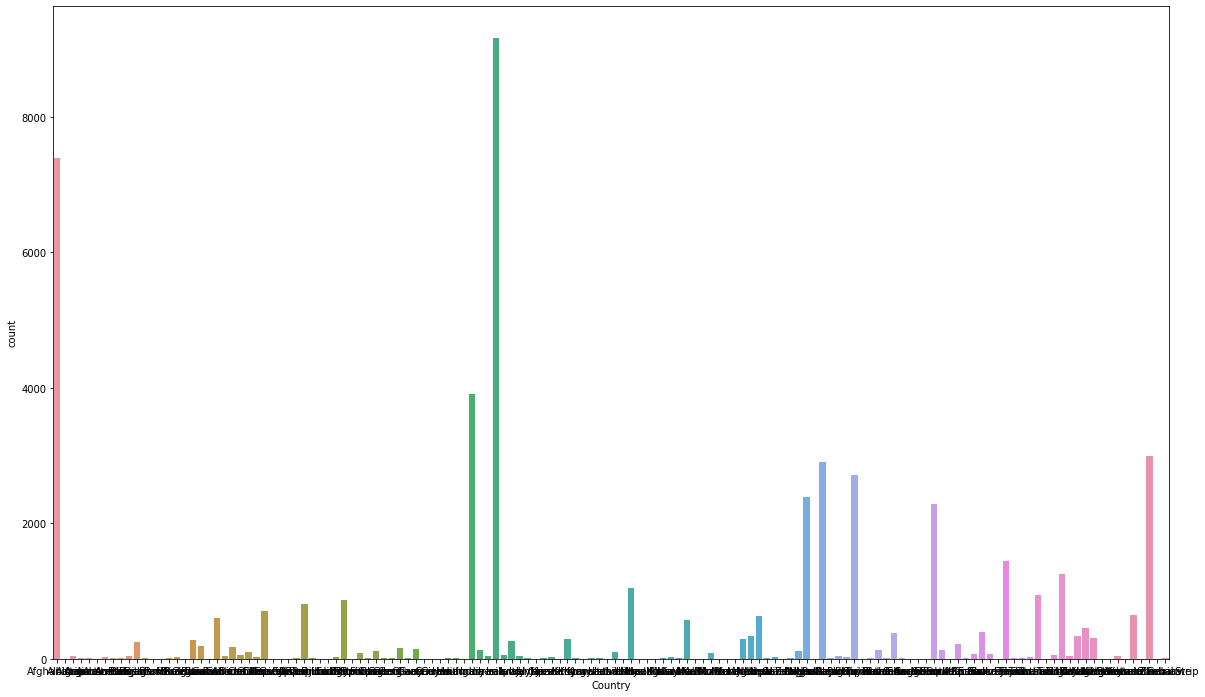

In [50]:
sns.countplot(country_df['Country'], label="Count")
plt.show()

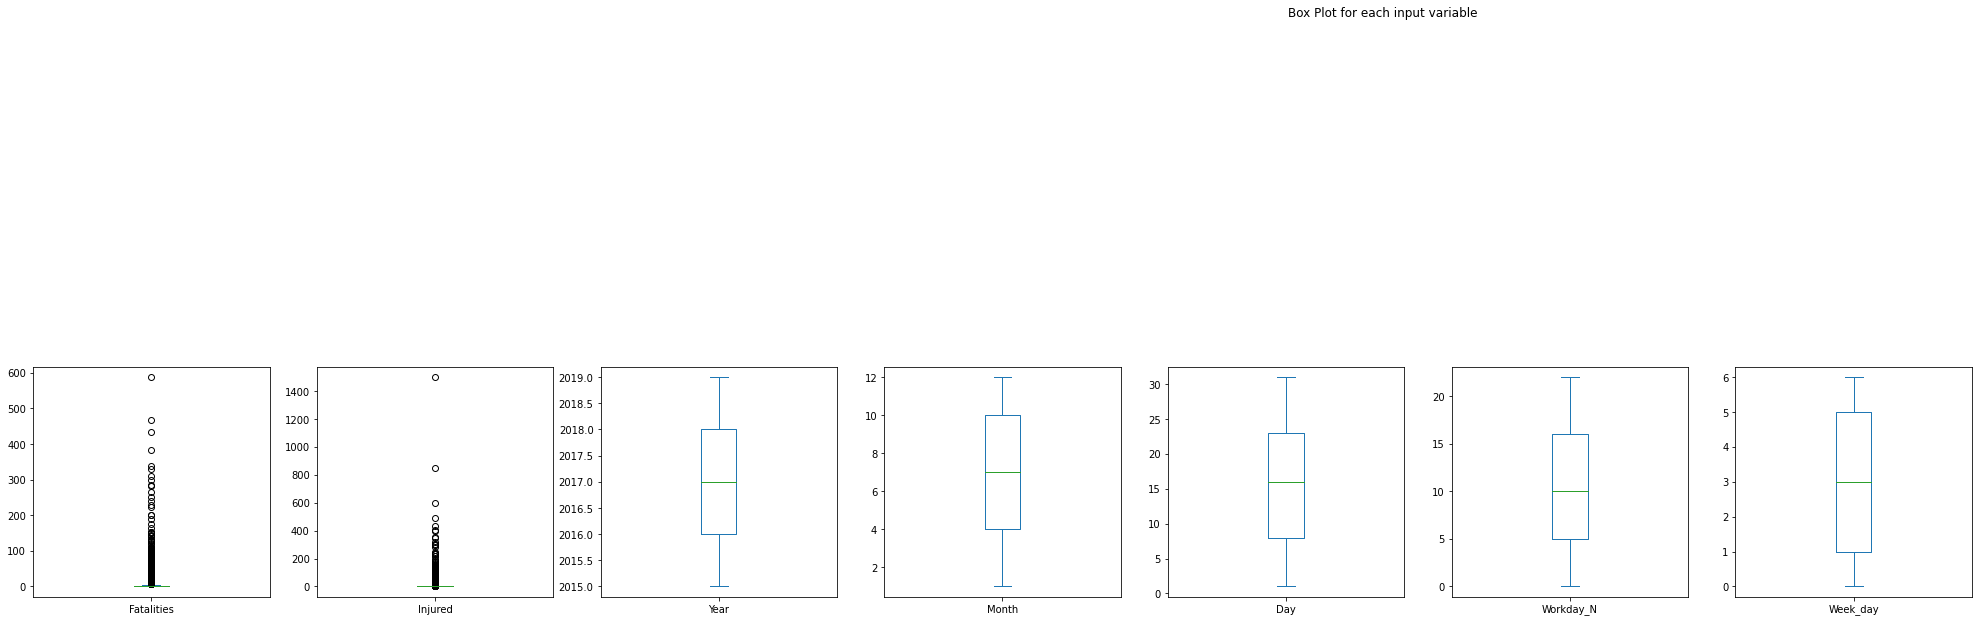

In [51]:
country_df.plot(kind='box', subplots=True, layout=(10,10), sharex=False, sharey=False, figsize=(50,50), title='Box Plot for each input variable')
plt.savefig('terror_box')
plt.show()

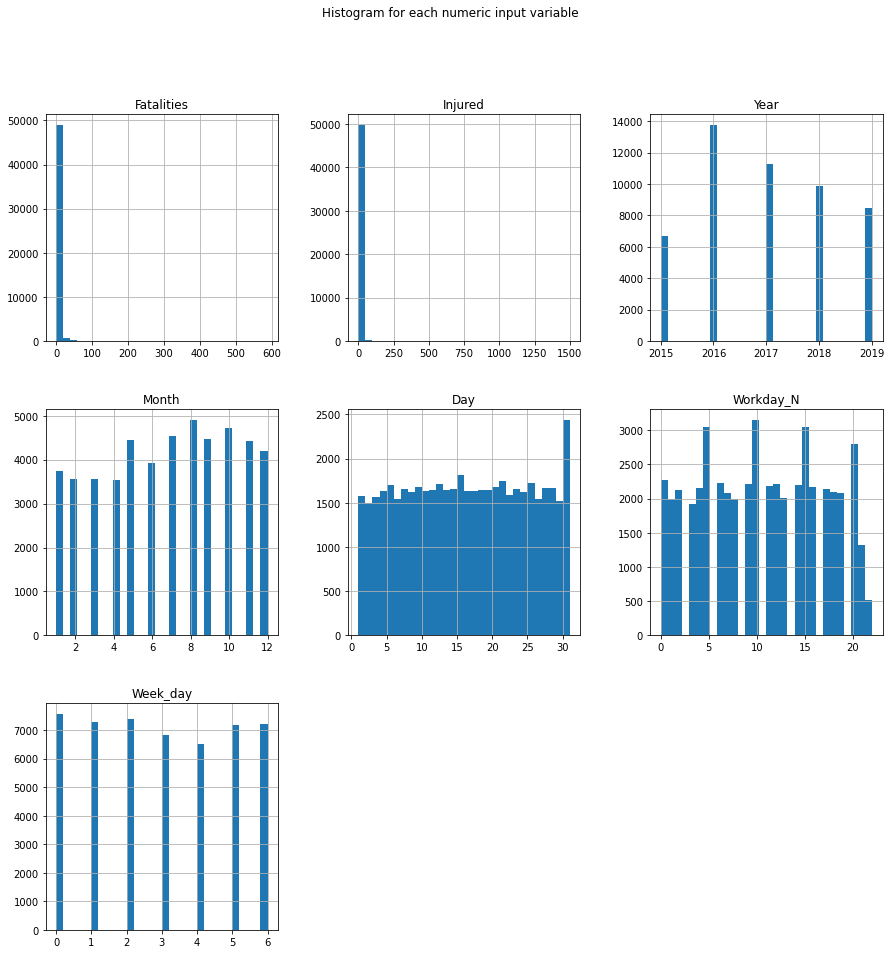

In [52]:
country_df.hist(bins=30, figsize=(15,15))
pl.suptitle("Histogram for each numeric input variable")
plt.savefig('terror_hist')
plt.show()

Since we wish to predict which countries of the next terror attack we need to convert all the categorical attributes to numeric.
therefore, I've add new columns for each categorical as numric code using LabelEncoder

In [53]:
LE = LabelEncoder()
country_df['Country_label'] = LE.fit_transform(country_df['Country'])
country_df['City_label'] = LE.fit_transform(country_df['City'])
country_df['Perpetrator_label'] = LE.fit_transform(country_df['Perpetrator'])
country_df['Target_label'] = LE.fit_transform(country_df['Target'])
country_df.head(10)

,Country,City,Perpetrator,Fatalities,Injured,Target,Year,Month,Day,Workday_N,Week_day,Country_label,City_label,Perpetrator_label,Target_label
Date,,,,,,,,,,,,,,,
2019-12-31,China,Hong Kong,Taliban,0,0,Government (General),2019,12,31,21,1,25,6667,1311,87
2019-12-31,India,Bagiot Dora,Taliban,0,1,Private Citizens & Property,2019,12,31,21,1,52,1772,1311,282
2019-12-31,Sudan,El Geneina,Taliban,2,0,"Government (General),Police",2019,12,31,21,1,116,5127,1311,117
2019-12-31,Sudan,El Geneina,Taliban,2,1,Police,2019,12,31,21,1,116,5127,1311,227
2019-12-31,Iraq,Baghdad,Taliban,0,0,Private Citizens & Property,2019,12,31,21,1,55,1764,1311,282
2019-12-30,Iraq,Nada,Islamic State of Iraq and the Levant (ISIL),1,0,Military,2019,12,30,20,0,55,11637,717,159
2019-12-31,Cameroon,Njap,Separatists,1,0,Private Citizens & Property,2019,12,31,21,1,20,12170,1235,282
2019-12-31,Myanmar,Unknown,Arakan Army (AA),0,0,Government (General),2019,12,31,21,1,87,16802,300,87
2019-12-31,Philippines,Inug-ug,Taliban,0,0,Private Citizens & Property,2019,12,31,21,1,100,6961,1311,282


In [54]:
len(country_df['Country_label'].unique())

140

Checking for any corraletion

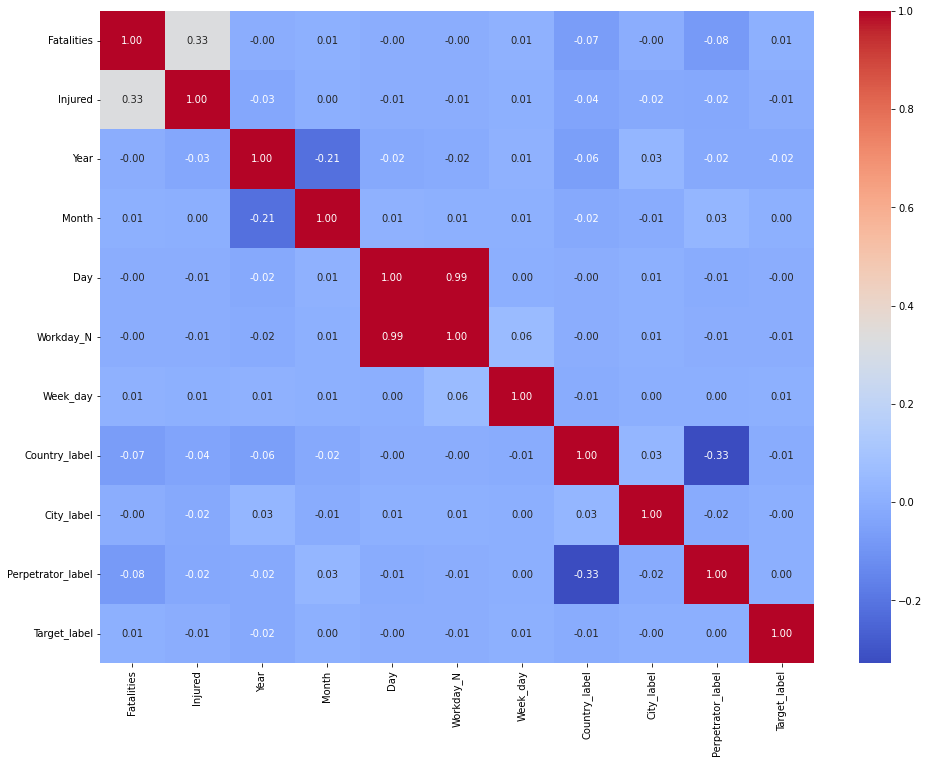

In [55]:
plt.figure(figsize=(16,12))
sns.heatmap(data=country_df.iloc[:,2:].corr(),annot=True,fmt='.2f',cmap='coolwarm')
plt.show()

In [56]:
train, test = train_test_split(country_df, test_size=0.3, shuffle=False)
training_features = ['Fatalities', 'Injured', 'Year', 'Month', 'Day',
'Workday_N', 'Week_day','City_label', 'Perpetrator_label','Target_label']
target = 'Country_label'
train_X = train[training_features]
train_Y = train[target]
test_X = test[training_features]
test_Y = test[target]

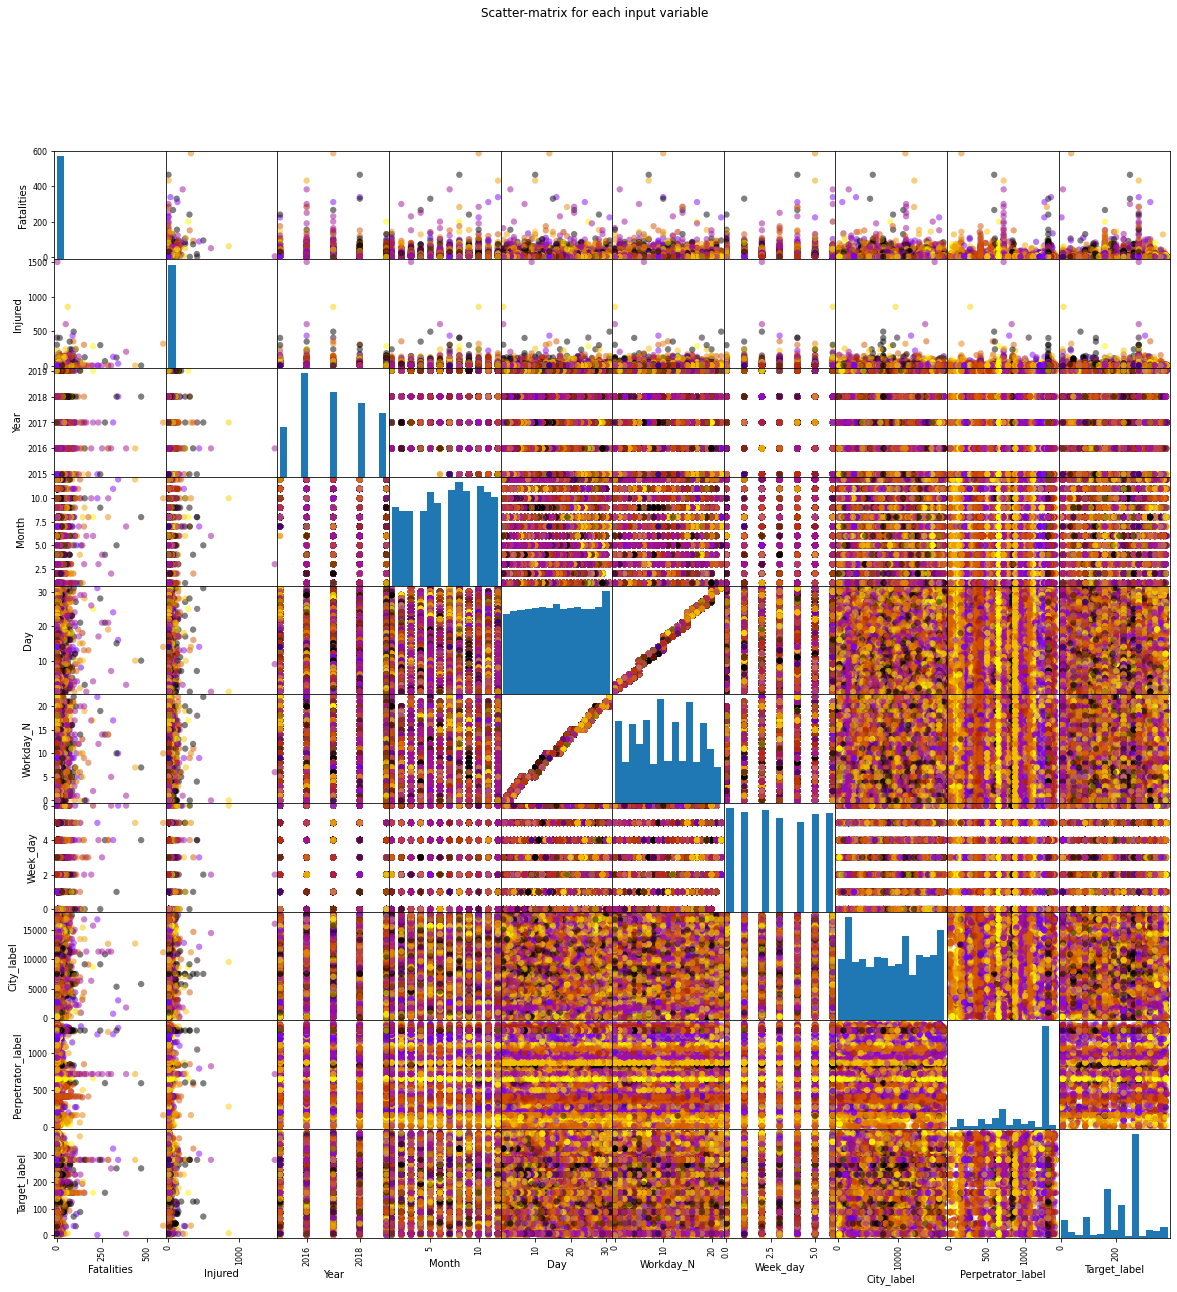

In [57]:
# feature_names = ['Fatalities', 'Injured', 'year', 'Target', 'Perpetrator']
X = country_df[training_features]
y = country_df['Country_label']

cmap = cm.get_cmap('gnuplot')
scatter = pd.plotting.scatter_matrix(X, c = y, marker = 'o', s=40, hist_kwds={'bins':15}, figsize=(20,20), cmap = cmap)
plt.suptitle('Scatter-matrix for each input variable')
plt.savefig('terror_scatter_matrix')

In [58]:
model = LinearRegression()
model.fit(train_X, train_Y)
train_pred_Y = model.predict(train_X)
test_pred_Y = model.predict(test_X)
train_pred_Y = pd.Series(train_pred_Y.clip(0, train_pred_Y.max()), index=train_Y.index)
test_pred_Y = pd.Series(test_pred_Y.clip(0, test_pred_Y.max()), index=test_Y.index)

rmse_train = np.sqrt(mean_squared_error(train_pred_Y, train_Y))
msle_train = mean_squared_log_error(train_pred_Y, train_Y)
rmse_test = np.sqrt(mean_squared_error(test_pred_Y, test_Y))
msle_test = mean_squared_log_error(test_pred_Y, test_Y)

print('rmse_train:',rmse_train,'msle_train:',msle_train)
print('rmse_test:',rmse_test,'msle_test:',msle_test)

rmse_train: 40.278371922252944 msle_train: 2.8394560317325515
rmse_test: 39.93834041420116 msle_test: 2.2545334846157457


In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [60]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
print('Accuracy of Logistic regression classifier on training set: {:.2f}'
     .format(logreg.score(X_train, y_train)))
print('Accuracy of Logistic regression classifier on test set: {:.2f}'
     .format(logreg.score(X_test, y_test)))

Accuracy of Logistic regression classifier on training set: 0.28
Accuracy of Logistic regression classifier on test set: 0.28


C:\Users\ornir\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [61]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier().fit(X_train, y_train)
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

Accuracy of Decision Tree classifier on training set: 1.00
Accuracy of Decision Tree classifier on test set: 0.66


In [62]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(X_test, y_test)))

Accuracy of K-NN classifier on training set: 0.51
Accuracy of K-NN classifier on test set: 0.33


In [63]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
print('Accuracy of LDA classifier on training set: {:.2f}'
     .format(lda.score(X_train, y_train)))
print('Accuracy of LDA classifier on test set: {:.2f}'
     .format(lda.score(X_test, y_test)))

Accuracy of LDA classifier on training set: 0.29
Accuracy of LDA classifier on test set: 0.29


In [64]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)
print('Accuracy of GNB classifier on training set: {:.2f}'
     .format(gnb.score(X_train, y_train)))
print('Accuracy of GNB classifier on test set: {:.2f}'
     .format(gnb.score(X_test, y_test)))

Accuracy of GNB classifier on training set: 0.09
Accuracy of GNB classifier on test set: 0.09


In [65]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
pred = clf.predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[1168    0    0 ...   11    0    0]
 [   0    0    0 ...    0    0    0]
 [   0    0    3 ...    1    0    0]
 ...
 [  21    0    0 ...  628    0    0]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0    1]]
              precision    recall  f1-score   support

           0       0.64      0.63      0.64      1850
           1       0.00      0.00      0.00         1
           2       0.33      0.33      0.33         9
           3       0.50      0.25      0.33         4
           4       0.67      0.67      0.67         3
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         6
           7       0.00      0.00      0.00         2
           9       0.14      0.09      0.11        11
          10       0.42      0.39      0.40        54
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         1
          14   

C:\Users\ornir\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ornir\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ornir\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 